### Dataset

Download the 2D OASIS-3 dataset from:

https://drive.google.com/drive/folders/1hzqyOthgmOmwJiMvexMjv3QJ5kgKnBcY?usp=drive_link

Update the ```dataset_root``` variable below to point to the 2D dataset on your system.

In [12]:
%load_ext autoreload
%autoreload 2

dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    SpatialPadd,
    CastToTyped,
    ConcatItemsd,
)
from monai.utils import set_determinism
from tqdm import tqdm

In [14]:
import pandas as pd
import os 
from enum import Enum
from monai.transforms import Transform

modality_names = ["MR T1w", "MR T2w", "MR T2*", "MR FLAIR", "MR TOF-MRA"]

def create_oasis_3_multimodal_dataset(csv_path: str, dataset_root: str, transform: Transform, cache_rate: float, missing_modality: str):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    train_data = []
    for index, row in train_df.iterrows():
        data_dict = {}
        has_non_empty = False
        for modality in modality_names:
            file_path = row[modality]
            if file_path:
                has_non_empty = True
                data_dict[modality] = os.path.join(dataset_root, file_path)
            else:
                if missing_modality == "zeros":
                    data_dict[modality] = "empty_volume_2d.nii.gz"
                elif missing_modality == "gauss":
                    data_dict[modality] = "gauss_2d_256.nii.gz"
                else:
                    raise ValueError(f"Invalid missing modality key {missing_modality}")
        if not has_non_empty:
            continue
        data_dict["label"] = row["label"]
        train_data.append(data_dict)
    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

class SafeCropForegroundd:
    def __init__(self, keys, source_key, select_fn, margin=0):
        self.source_key = source_key
        self.crop_foreground = CropForegroundd(keys=keys, source_key=source_key, select_fn=select_fn, margin=margin)

    def __call__(self, data):
        cropped_data = self.crop_foreground(data.copy())
        cropped_image = cropped_data[self.source_key]

        # Check if any dimension (excluding batch and channel dimensions) is zero.
        if np.any(np.asarray(cropped_image.shape[1:]) == 0):
            return data  # Revert to original data if cropped size is zero in any dimension
        
        return cropped_data

In [15]:
resolution = 256
cache_rate = 0.1
batch_size = 4
missing_modality = "gauss"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
foreground_crop_threshold = 0.1
transform_list = [
        LoadImaged(keys=modality_names, image_only=True),
        EnsureChannelFirstd(keys=modality_names + ["label"], channel_dim="no_channel"),
        CastToTyped("label", dtype=np.float64),
        ScaleIntensityd(keys=modality_names),
    ]
for i in range(len(modality_names)):
     transform_list.append(
         SafeCropForegroundd(keys=modality_names[i], source_key=modality_names[i], select_fn=lambda x: x > foreground_crop_threshold, margin=5)
     )
transform_list.extend([
    Resized(keys=modality_names, spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=modality_names, spatial_size=(resolution, resolution)),
    ConcatItemsd(keys=modality_names, name="image"),
    EnsureTyped(keys=["image"], device=device),
]
)
transform = Compose(transform_list)

train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
train_ds = create_oasis_3_multimodal_dataset(csv_path=train_table_path, dataset_root=dataset_root, transform=transform, cache_rate=cache_rate, missing_modality=missing_modality)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch_size, shuffle=True)

val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_multimodal_dataset(csv_path=val_table_path, dataset_root=dataset_root, transform=transform, cache_rate=cache_rate, missing_modality=missing_modality)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)

Loading dataset: 100%|██████████| 28/28 [00:02<00:00,  9.95it/s]


MR T1w


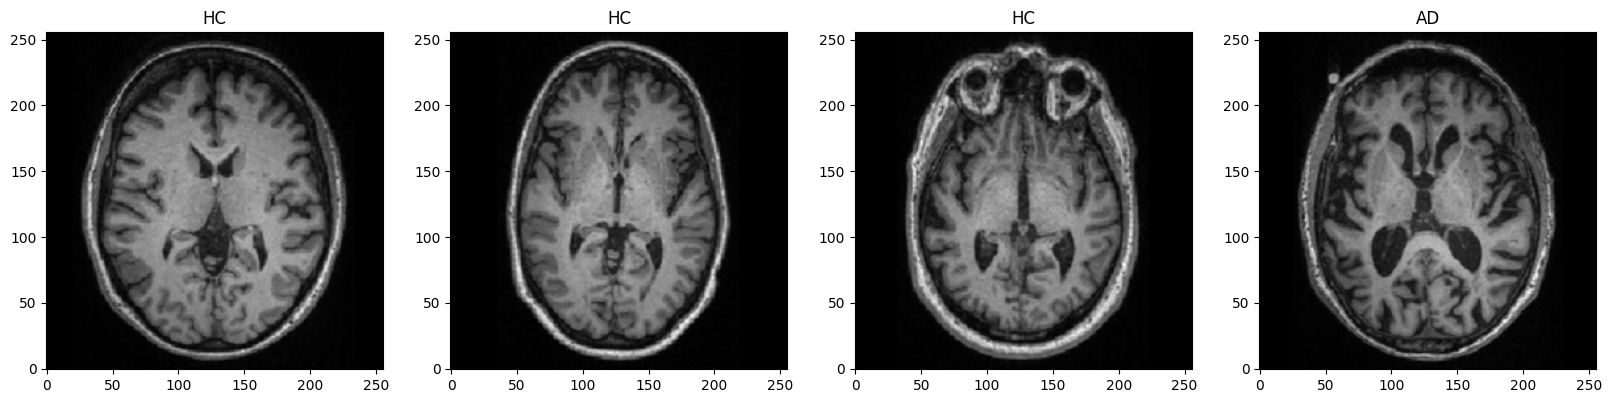

MR T2w


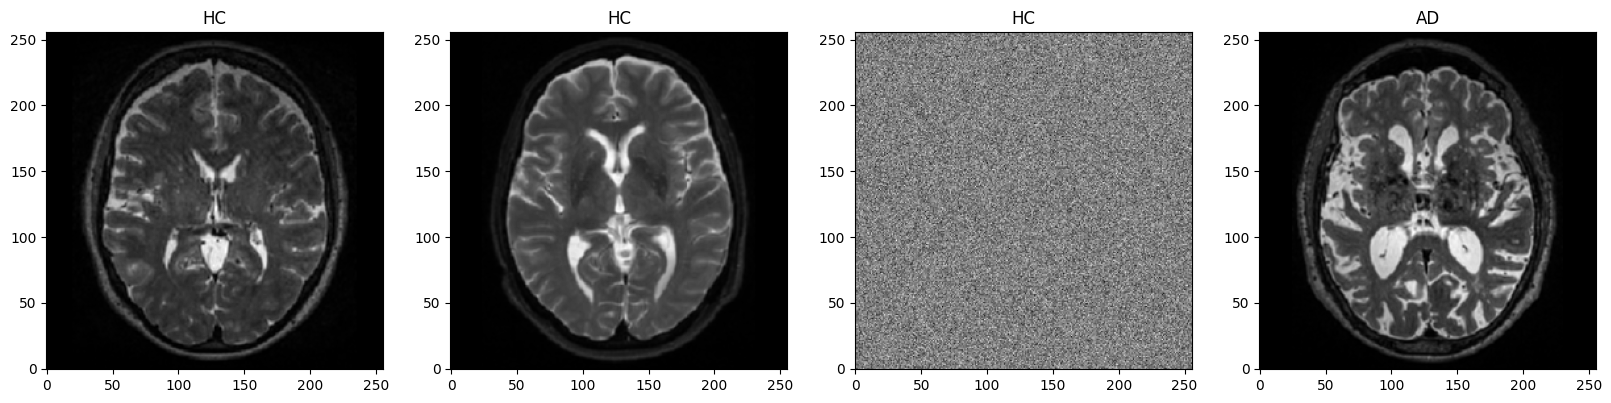

MR T2*


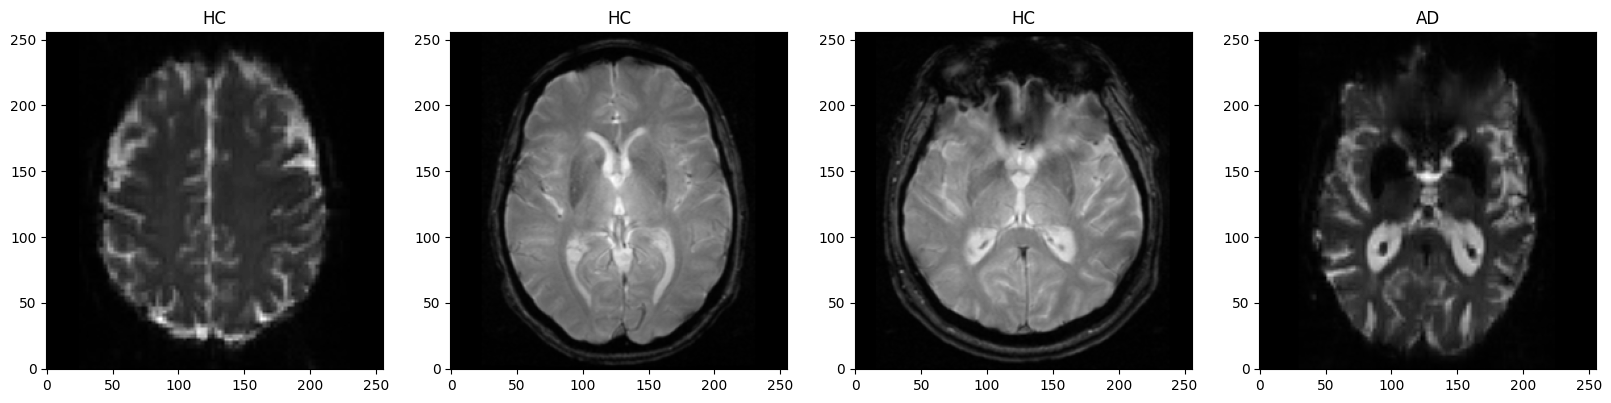

MR FLAIR


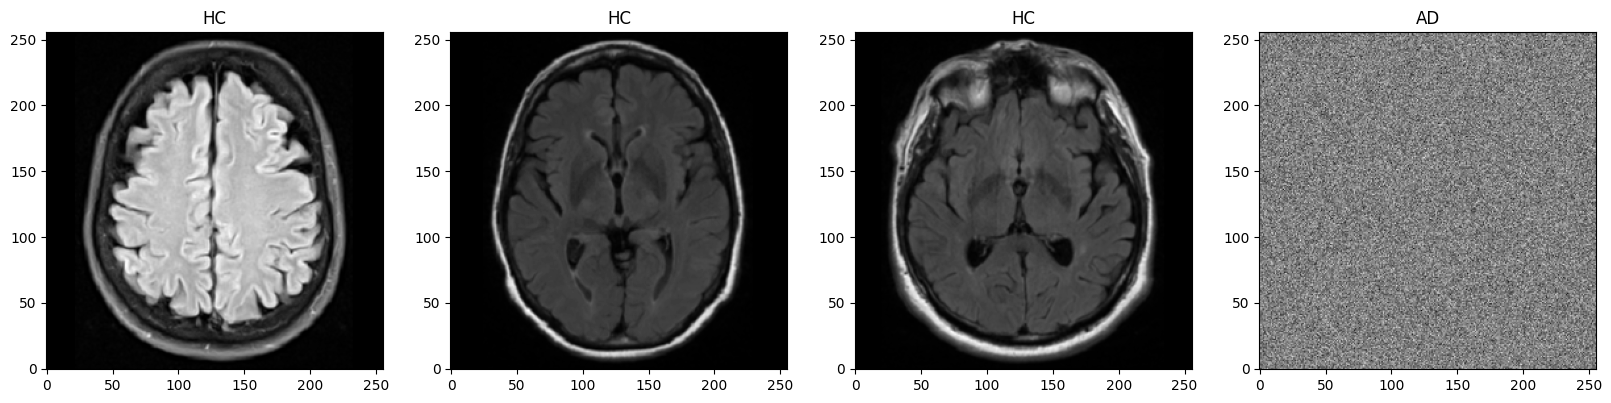

MR TOF-MRA


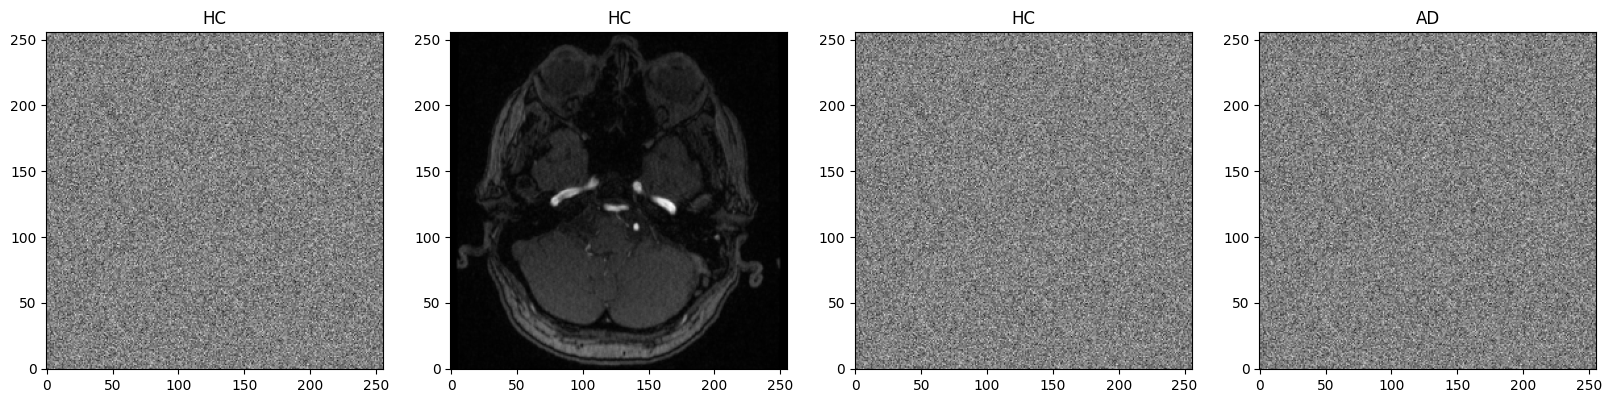

In [16]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

for mod_index in range(len(modality_names)):
    print(modality_names[mod_index])
    plt.figure(figsize=(20, 12))
    i = 0
    for sample_data, sample_label in zip(images, labels):
        sample = sample_data.cpu()[mod_index]
        plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
        plt.imshow(sample.T, cmap='gray', origin='lower')
        plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
        i += 1
    plt.show()

### Define network and optimizer

In [10]:
model = DenseNet121(spatial_dims=2, in_channels=len(modality_names), out_channels=1).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
scaler = torch.cuda.amp.GradScaler()
max_epochs = 8
val_interval = 1
auc_metric = ROCAUCMetric()
out_model_dir = "./pretrained/"
model_file_name = f"DenseNet121_ad_cls_oasis_3.pth"
model_file_name

'DenseNet121_ad_cls_oasis_3.pth'

### Training

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

y_pred_trans = Compose([Activations(sigmoid=True)])

for epoch in range(max_epochs):
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_data in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} / {max_epochs}")

            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            tepoch.set_postfix(loss=loss.item())

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = torch.cat([i for i in decollate_batch(y, detach=False)], dim=0)
            y_pred_act = torch.cat([y_pred_trans(i) for i in decollate_batch(y_pred)], dim=0)
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(result)
            acc_value = torch.eq((y_pred_act > 0.5).long(), y)
            acc_metric = acc_value.float().mean().item()
            del y_pred_act, y_onehot
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(out_model_dir, model_file_name))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"Training completed, best_metric (AUC): {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

  0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 0 / 8: 100%|██████████| 160/160 [01:57<00:00,  1.36batch/s, loss=0.56] 


saved new best metric model
current epoch: 1 current AUC: 0.7410 current accuracy: 0.7891 best AUC: 0.7410 at epoch: 1


Epoch 1 / 8: 100%|██████████| 160/160 [02:00<00:00,  1.33batch/s, loss=0.264]


saved new best metric model
current epoch: 2 current AUC: 0.7501 current accuracy: 0.7761 best AUC: 0.7501 at epoch: 2


Epoch 2 / 8:  21%|██        | 33/160 [00:26<01:43,  1.23batch/s, loss=0.522]


KeyboardInterrupt: 